In [2]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git

In [3]:
%matplotlib widget
from segment_anything import sam_model_registry
from utils.demo import BboxPromptDemo
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
device = "cpu"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [4]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
from torch.utils.data import Dataset
import cv2

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [5]:
def pad_image(image, target_size):
    """
    Expects a numpy array with shape HxWxC in uint8 format.
    """
    # Pad
    h, w = image.shape[0], image.shape[1]
    padh = target_size - h
    padw = target_size - w
    if len(image.shape) == 3: ## Pad image
        image_padded = np.pad(image, ((0, padh), (0, padw), (0, 0)))
    else: ## Pad gt mask
        image_padded = np.pad(image, ((0, padh), (0, padw)))

    return image_padded


# Function to get bounding box coordinates from the mask
def get_bbox1024(mask_1024, bbox_shift=3):
    """
    Get the bounding box coordinates from the mask (256x256)

    Parameters
    ----------
    mask_256 : numpy.ndarray
        the mask of the resized image

    bbox_shift : int
        Add perturbation to the bounding box coordinates
    
    Returns
    -------
    numpy.ndarray
        bounding box coordinates in the resized image
    """
    y_indices, x_indices = np.where(mask_1024 > 0)
    
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates and test the robustness
    # this can be removed if you do not want to test the robustness
    H, W = mask_1024.shape
    x_min = max(0, x_min - bbox_shift)
    x_max = min(W, x_max + bbox_shift)
    y_min = max(0, y_min - bbox_shift)
    y_max = min(H, y_max + bbox_shift)

    bboxes1024 = np.array([x_min, y_min, x_max, y_max])

    return bboxes1024

# Function to rescale bounding box to the coordinates of the resized image
def resize_box_to_1024(box, original_size):
    """
    the input bounding box is obtained from the original image
    here, we rescale it to the coordinates of the resized image

    Parameters
    ----------
    box : numpy.ndarray
        bounding box coordinates in the original image
    original_size : tuple
        the original size of the image

    Returns
    -------
    numpy.ndarray
        bounding box coordinates in the resized image
    """
    new_box = np.zeros_like(box)
    ratio = 1024 / max(original_size)
    for i in range(len(box)):
        new_box[i] = int(box[i] * ratio)

    return new_box

# Function to resize image to target_length while keeping the aspect ratio
def resize_longest_side(image, target_length=1024):
    """
    Resize image to target_length while keeping the aspect ratio
    Expects a numpy array with shape HxWxC in uint8 format.
    """
    oldh, oldw = image.shape[0], image.shape[1]
    scale = target_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww, newh = int(neww + 0.5), int(newh + 0.5)
    target_size = (neww, newh)

    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)


In [6]:
class npyDataset(Dataset):    
    def __init__(self, data_root_folder = 'data', folder = 'train', n_sample=None):
        self.main_folder = os.path.join(data_root_folder, folder)
        self.imgs_path = os.path.join(data_root_folder, folder + '_final_npy/imgs')
        self.gts_path = os.path.join(data_root_folder, folder + '_final_npy/gts')
        temp1 =  [f for f in os.listdir(self.imgs_path) if f.endswith('.npy')]
        temp2 =  [f for f in os.listdir(self.gts_path) if f.endswith('.npy')]
        if n_sample is not None:
            self.imgs = sorted(temp1)[:n_sample]
            self.gts = sorted(temp2)[:n_sample]
        else:
            self.imgs = sorted(temp1)
            self.gts = sorted(temp2)

        assert len(self.imgs) == len(self.gts), "Number of images and masks should be same."

    def __getitem__(self, index):
        img_file_name = self.imgs[index]
        img = np.load(os.path.join(self.imgs_path, img_file_name), allow_pickle=True)
        # img_1024 = pad_image(img, 1024
        #                      )
        img_tensor = torch.tensor(img).float().permute(2, 1, 0)
        img_1024 = resize_longest_side(img, 1024)
        img_1024_tensor = torch.tensor(img_1024).float().permute(2, 1, 0)

        gt = np.load(os.path.join(self.gts_path, img_file_name), allow_pickle=True)
        gt[gt > 0] = 1
        # gt = pad_image(gt, 1024
        #                      )
        gt_original = torch.from_numpy(gt).float().unsqueeze(0)
        original_box = get_bbox1024(gt)
        gt = resize_longest_side(gt, 1024) # 512 -> 256
        gt_tensor = torch.from_numpy(gt).float().unsqueeze(0) # 512, 512
        box512 = get_bbox1024(gt)
        box1024 = resize_box_to_1024(box512, original_size=(1024, 1024))
        box1024 = box1024[None, ...] # (1, 4)
        return {
            'image': img_1024_tensor,
            'mask': gt_tensor,
            'mask_original': gt_original,
            'box_np': box1024,
            'img_original': img_tensor,
            'box_original': original_box
        }
 
    def __len__(self):
        return len(self.imgs)

In [7]:
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
H = 512
W = 512
BATCH_SIZE=1
path = r'C:\Users\lisag\OneDrive\Bureau\Columbia_Coursework\Spring_2023\DLBI\HematomaSegmentation-VolumePrediction\data'
val_dataset = npyDataset(data_root_folder=path, folder='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = npyDataset(data_root_folder=path, folder='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# Training loop
# Initialize metrics and metrics lists
from torchmetrics.classification import BinaryJaccardIndex, Dice
import tqdm
from time import time
from tqdm.notebook import tqdm

def dice_coeff_binary(y_pred, y_true):
        """Values must be only zero or one."""
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1).float(), y_true.view(-1).float())
        union = torch.sum(y_pred.float()) + torch.sum(y_true.float())
        return ((2 * inter.float() + eps) / (union.float() + eps))

start_time = time()
valid_batch_dice = []
valid_batch_jaccard = []
jaccard_index_metric = BinaryJaccardIndex()

with torch.no_grad():
    for i, batch in enumerate(tqdm(val_dataloader)):
        if i%100 == 99:
            print("Iteration nb: ", i)
            print("Elapsed time:", time() - start_time)
#         print("Iteration ", i)
        # get image and masks from dataloader, change nb channels = 3
        imgs = batch['image'].to(device).float()
        img_masks = batch['mask'] #.to(device).float()
        mask_original = batch['mask_original']
        image_embedding = medsam_model.image_encoder(imgs.to('cpu'))
        box_1024 = batch['box_np']
        output = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
        y_pred = torch.from_numpy(output).unsqueeze(dim=0)
        y_true = mask_original[0]

        batch_dice_score = dice_coeff_binary(y_pred, y_true)
#         print("Dice", batch_dice_score)
        valid_batch_dice.append(batch_dice_score)

        batch_jaccard_score = jaccard_index_metric(y_pred, y_true)
#         print("Jaccard", batch_jaccard_score)
        valid_batch_jaccard.append(batch_jaccard_score)

#         print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {loss.item()}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}', end='\r')

In [34]:
print(np.mean(valid_batch_dice)) # valid average batch dice score is 0.8125727

0.8125727


In [35]:
print(np.mean(valid_batch_jaccard)) # valid average batch jaccard score is 0.70051867

0.70051867


In [38]:
# Training loop
# Initialize metrics and metrics lists
from torchmetrics.classification import BinaryJaccardIndex, Dice
import tqdm
from time import time
from tqdm.notebook import tqdm

def dice_coeff_binary(y_pred, y_true):
        """Values must be only zero or one."""
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1).float(), y_true.view(-1).float())
        union = torch.sum(y_pred.float()) + torch.sum(y_true.float())
        return ((2 * inter.float() + eps) / (union.float() + eps))

start_time = time()
test_batch_dice = []
test_batch_jaccard = []
jaccard_index_metric = BinaryJaccardIndex()

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader)):
        if i%100 == 99:
            print("Iteration nb: ", i)
            print("Elapsed time:", time() - start_time)
#         print("Iteration ", i)
        # get image and masks from dataloader, change nb channels = 3
        imgs = batch['image'].to(device).float()
        img_masks = batch['mask'] #.to(device).float()
        mask_original = batch['mask_original']
        image_embedding = medsam_model.image_encoder(imgs.to('cpu'))
        box_1024 = batch['box_np']
        output = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
        y_pred = torch.from_numpy(output).unsqueeze(dim=0)
        y_true = mask_original[0]

        batch_dice_score = dice_coeff_binary(y_pred, y_true)
#         print("Dice", batch_dice_score)
        test_batch_dice.append(batch_dice_score)

        batch_jaccard_score = jaccard_index_metric(y_pred, y_true)
#         print("Jaccard", batch_jaccard_score)
        test_batch_jaccard.append(batch_jaccard_score)

#         print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {loss.item()}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}', end='\r')

  0%|          | 0/897 [00:00<?, ?it/s]

Iteration nb:  99
Elapsed time: 664.7265253067017
Iteration nb:  199
Elapsed time: 1346.6257679462433
Iteration nb:  299
Elapsed time: 2027.3010470867157
Iteration nb:  399
Elapsed time: 2733.1143684387207
Iteration nb:  499
Elapsed time: 3437.969474554062
Iteration nb:  599
Elapsed time: 4145.586995840073
Iteration nb:  699
Elapsed time: 4817.4304032325745
Iteration nb:  799
Elapsed time: 5456.020794391632


In [39]:
print(np.mean(test_batch_dice)) # test average batch dice score is 0.8468964)

0.8468964


In [40]:
print(np.mean(test_batch_jaccard)) # test average batch dice score is 0.74986583)

0.74986583


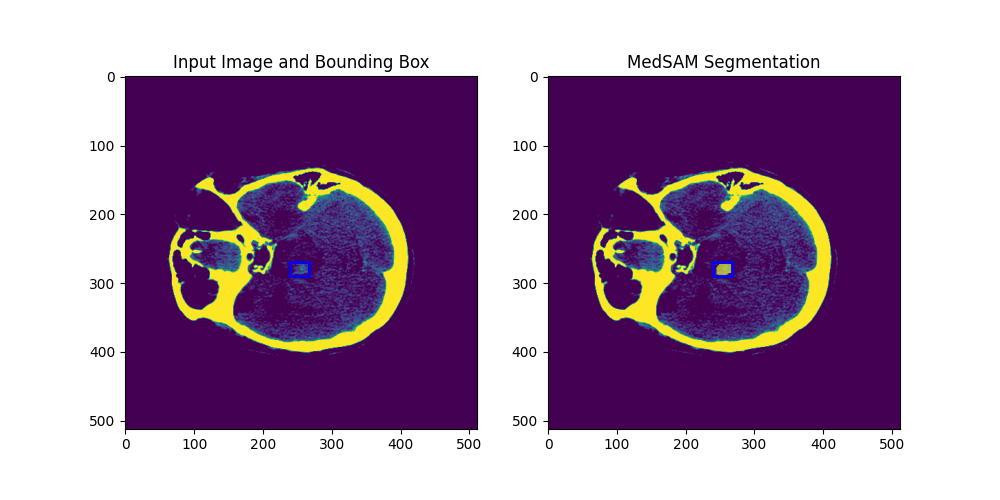

In [197]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_original[0][0])
show_box(box_original[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_original[0][0])
show_mask(medsam_seg, ax[1])
show_box(box_original[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()